In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import glob
import time
import pickle
import random
import pathlib
import datetime

# from IPython import display
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from scipy.ndimage import gaussian_filter

2023-07-28 09:17:35.180688: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-28 09:17:37.677988: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-28 09:17:54.625816: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
RESULTS_FOLDER = 'results'

In [4]:
### Configuration
os.mkdir(RESULTS_FOLDER) if not os.path.isdir(RESULTS_FOLDER) else None
folders = ['all_exp_plots_g', 'all_exp_plots', 'exp_plots', 'model_weights', 'raw_exps', 'training_plots', 'all_val_plots', 'raw_vals']
for folder in folders:
    if(not os.path.isdir(f'{RESULTS_FOLDER}/{folder}')):
        os.mkdir(f'{RESULTS_FOLDER}/{folder}')

In [5]:
tf.random.set_seed(seed=20)

In [6]:
### Hyperparameters
BATCH_SIZE = 128
EPOCH = 100
# BATCH_SIZE = 32
# EPOCH = 1

### Load dataset 

In [7]:
### Normalization

In [8]:
def add_noise_blur(image, rows=128, cols=128):
    #add random noise
    scale = tf.random.uniform([1], minval = 0.01, maxval = 0.1, dtype = tf.float32 )
    noise = tf.random.normal([rows, cols, 1], mean = 0.0, stddev = 1.0)
    #blur with a random sigma
    # sigmaIn = np.random.uniform(low = 1.0, high = 2.0 )
    sigmaIn = tf.random.uniform(shape=[], minval = 1.0, maxval = 2.0 )
    #image = gaussian_filter(image, sigma = sigmaIn)
    noise = gaussian_filter(noise, sigma = sigmaIn.numpy())
    image *= (1.0 + scale*noise)
    #print("scale %f sigma %f" % (scale, sigmaIn))
    return image

In [9]:
def normalize(dataY):
    max = tf.reduce_max(dataY)
    min = tf.reduce_min(dataY)
    # dataY = dataY / tf.math.abs(min)
    dataY = (dataY - min)/(max - min)
    return dataY

In [10]:
def normalizeTarget(image, bFlag = False):
    image = (image - 1.0) / (5.0)
    if bFlag:
        image = 2.0*image - 1.0
    return image

In [11]:
### EoNormalization

In [12]:
def load(image_file, image_size=(128,128)):
    # input_image = np.fromfile(image_file, dtype = 'float32', sep="")
    input_image = tf.io.read_file(image_file)
    input_image = tf.io.decode_raw(input_image, tf.float32)
    input_image = tf.reshape(input_image, image_size)
    input_image = tf.expand_dims(input_image, -1)
    return input_image

In [13]:
def normalize_val(image, target):
    input_image = add_noise_blur(image)
    return input_image , target

In [14]:
def load_image_train(image_file, target_file):
    input_image = load(image_file)
    target_image = load(target_file)
    input_image = normalize(input_image)
    return input_image , target_image 

In [15]:
def load_image_val(image_file, target_file):    
    input_image = load(image_file)
    target_image = load(target_file)
    # input_image = add_noise_blur(image_file)
    input_image = normalize(input_image)
    return input_image , target_image 

In [16]:
def check_count(log_path):
    soft = 0
    hard = 0
    for lp in log_path:
        with open(lp) as f:
            data = f.read()
        data = data.split(' ')
        mod = data[9]
        assert mod == 'mod1'
        mod_value = float(data[10].splitlines()[0])
        if mod_value < 1.0:
            soft = soft + 1
        if mod_value > 1.0:
            hard = hard + 1
    return soft, hard

In [18]:
def get_dataset_partitions_tf(ds, ds_size, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=False, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    if shuffle:
        # Specify seed to always have the same split distribution between runs
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [17]:
# input_path = glob.glob('data/TrainData*/*/uY_128x128*.raw')
# target_path = glob.glob('data/TrainData*/*/modulus_128x128*.raw')
# # input_path.sort(key= lambda x: int(x.split('/')[-2]))
# # target_path.sort(key= lambda x: int(x.split('/')[-2]))

In [18]:
input_path = glob.glob('alldata/TrainData/*/uY_128x128.raw')
target_path = glob.glob('alldata/TrainData/*/modulus_128x128.raw')
log_path = glob.glob('alldata/TrainData/*/logFile.txt')
input_path.sort(key= lambda x: int(x.split('/')[-2]))
target_path.sort(key= lambda x: int(x.split('/')[-2]))
log_path.sort(key= lambda x: int(x.split('/')[-2]))

In [19]:
len(input_path)

10000

In [20]:
len(target_path)

10000

In [23]:
check_count(log_path)

(4966, 5034)

In [24]:
input_val_path = glob.glob('alldata/ValData/*/uY_128x128.raw')
target_val_path = glob.glob('alldata/ValData/*/modulus_128x128.raw')
log_val_path = glob.glob('alldata/ValData/*/logFile.txt')
input_val_path.sort(key= lambda x: int(x.split('/')[-2]))
target_val_path.sort(key= lambda x: int(x.split('/')[-2]))
log_val_path.sort(key= lambda x: int(x.split('/')[-2]))

In [25]:
check_count(log_val_path)

(495, 505)

In [26]:
# train_dataset
train_dataset = tf.data.Dataset.from_tensor_slices((input_path, target_path))
train_dataset = train_dataset.map(load_image_train)
train_dataset = train_dataset.shuffle(buffer_size=len(input_path)) 
train_dataset = train_dataset.batch(BATCH_SIZE)

2023-07-28 09:22:22.521661: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38201 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:1b:00.0, compute capability: 8.0
2023-07-28 09:22:22.522868: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 6838 MB memory:  -> device: 1, name: Tesla P4, pci bus id: 0000:1c:00.0, compute capability: 6.1


In [27]:
len(train_dataset)

79

In [28]:
# train_dataset, val_dataset, test_dataset = get_dataset_partitions_tf(train_dataset, len(train_dataset))
# print(len(train_dataset), len(val_dataset), len(test_dataset))

In [62]:
## val_dataset
val_dataset = tf.data.Dataset.from_tensor_slices((input_val_path, target_val_path))
val_dataset = val_dataset.map(load_image_val)
# val_dataset = val_dataset.shuffle(buffer_size=len(input_val_path)) 
# val_dataset = val_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.batch(1)

In [30]:
# print(len(dataset))
print(len(train_dataset))
print(len(val_dataset))
# print(len(test_dataset))

79
1000


In [31]:
a = next(iter(train_dataset))
print(len(a))
print(a[0].shape)
print(a[1].shape)

2023-07-28 09:22:41.203665: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [10000]
	 [[{{node Placeholder/_0}}]]
2023-07-28 09:22:51.215573: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 549 of 10000
2023-07-28 09:23:01.223846: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1189 of 10000
2023-07-28 09:23:11.232145: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2026 of 10000
2023-07-28 09:23:21.221687: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2886 of 10000
2023-07-28 09:23:31.220541: I tensorflow/core/kernel

2
(128, 128, 128, 1)
(128, 128, 128, 1)


2023-07-28 09:24:46.260436: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


In [32]:
inp, re = a[0][0], a[1][0]

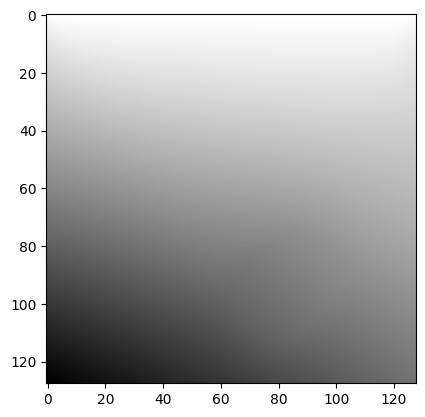

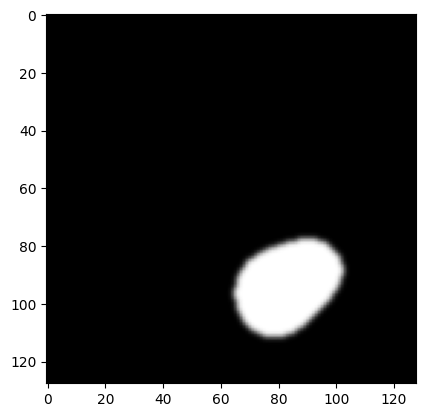

In [33]:
plt.figure()
plt.imshow(inp, cmap='gray')
plt.figure()
plt.imshow(re, cmap='gray')

In [34]:
len(val_dataset)

1000

In [35]:
# val_dataset = val_dataset.batch(1)

In [36]:
len(val_dataset)

1000

### Generator Model

In [37]:
OUTPUT_CHANNELS = 1

In [38]:
def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                                kernel_initializer=initializer, use_bias=False))
    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())
    result.add(tf.keras.layers.LeakyReLU())
    return result

In [39]:
down_model = downsample(3, 4)
down_result = down_model(tf.expand_dims(inp, 0))
print (down_result.shape)

2023-07-28 09:26:09.403845: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8902


(1, 64, 64, 3)


2023-07-28 09:26:13.913604: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:109] Couldn't get ptxas version : FAILED_PRECONDITION: Couldn't get ptxas/nvlink version string: INTERNAL: Running ptxas --version returned 32512
2023-07-28 09:26:13.968176: W tensorflow/compiler/xla/stream_executor/gpu/redzone_allocator.cc:317] INTERNAL: ptxas exited with non-zero error code 32512, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


In [40]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                        padding='same',
                                        kernel_initializer=initializer,
                                        use_bias=False))
    result.add(tf.keras.layers.BatchNormalization())
    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))
    result.add(tf.keras.layers.ReLU())
    return result

In [41]:
up_model = upsample(3, 4)
up_result = up_model(down_result)
print (up_result.shape)

(1, 128, 128, 3)


In [42]:
def Generator():
    inputs = tf.keras.layers.Input(shape=[128, 128, 1])

    # down_stack = [
    #     downsample(64, 3, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
    #     downsample(128, 3),  # (batch_size, 64, 64, 128)
    #     downsample(256, 3),  # (batch_size, 32, 32, 256)
    #     downsample(512, 3),  # (batch_size, 16, 16, 512)
    #     downsample(512, 3),  # (batch_size, 8, 8, 512)
    #     downsample(512, 3),  # (batch_size, 4, 4, 512)
    #     downsample(512, 3),  # (batch_size, 2, 2, 512)
    #     # downsample(512, 4),  # (batch_size, 1, 1, 512)
    # ]
    down_stack = [
        downsample(64, 4, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
        downsample(128, 4),  # (batch_size, 64, 64, 128)
        downsample(256, 4),  # (batch_size, 32, 32, 256)
        downsample(512, 4),  # (batch_size, 16, 16, 512)
        downsample(512, 4),  # (batch_size, 8, 8, 512)
        downsample(512, 4),  # (batch_size, 4, 4, 512)
        downsample(512, 4),  # (batch_size, 2, 2, 512)
        # downsample(512, 4),  # (batch_size, 1, 1, 512)
    ]

    # up_stack = [
    #     # upsample(512, 4, apply_dropout=True),  # (batch_size, 2, 2, 1024)
    #     upsample(512, 3, apply_dropout=True),  # (batch_size, 4, 4, 1024)
    #     upsample(512, 3, apply_dropout=False),  # (batch_size, 8, 8, 1024)
    #     upsample(512, 3),  # (batch_size, 16, 16, 1024)
    #     upsample(256, 3),  # (batch_size, 32, 32, 512)
    #     upsample(128, 3),  # (batch_size, 64, 64, 256)
    #     upsample(64, 3),  # (batch_size, 128, 128, 128)
    # ]

    up_stack = [
        upsample(512, 4, apply_dropout=True),  # (batch_size, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True),  # (batch_size, 8, 8, 1024)
        upsample(512, 4),  # (batch_size, 16, 16, 1024)
        upsample(256, 4),  # (batch_size, 32, 32, 512)
        upsample(128, 4),  # (batch_size, 64, 64, 256)
        # upsample(64, 4),  # (batch_size, 128, 128, 128)
    ]

    
    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 3,
                                            strides=2,
                                            padding='same',
                                            kernel_initializer=initializer,
                                            activation='sigmoid')  # (batch_size, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])

    # x = last(x)
    # x = 1.0 + (10.0 - 1.0)*x 

    upsampling = tf.keras.layers.UpSampling2D(size=2, interpolation = 'bilinear')
    # last_conv = tf.keras.layers.Conv2D(1, kernel_size=3, strides=1, padding='same', activation='relu')
    last_conv = tf.keras.layers.Conv2D(1, kernel_size=3, strides=1, padding='same', activation='sigmoid')
    multiply = tf.keras.layers.Lambda(lambda x: 0.1 + (5.0 - 0.1)*x)
    
    x = upsampling(x)
    x = last_conv(x)
    x = multiply(x)
    
    # x = 0.1 + (10.0 - 0.1)*x
    # this one for both!

    return tf.keras.Model(inputs=inputs, outputs=x)

In [43]:
# Visualizing generator architecture
generator = Generator()
# tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

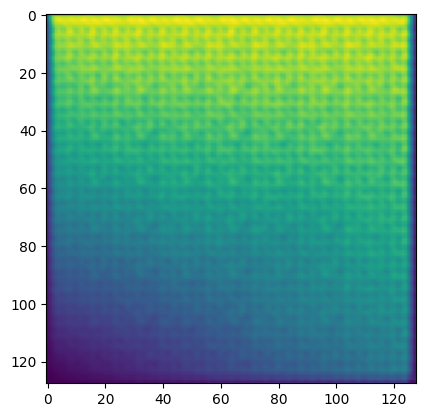

In [44]:
# Testing the generator
gen_output = generator(inp[tf.newaxis, ...], training=False)
plt.imshow(gen_output[0, ...])

In [45]:
# gen_output[0]

In [46]:
gen_output.shape

TensorShape([1, 128, 128, 1])

In [47]:
# Generator loss
LAMBDA = 100
loss_object = tf.keras.losses.MeanSquaredError()
loss_tracker = tf.keras.metrics.Mean(name="loss")
val_loss_tracker = tf.keras.metrics.Mean(name="loss")

In [48]:
def generator_loss(gen_output, target):
    #Possible addition: regularizer
    gan_loss = loss_object(gen_output, target)
    return gan_loss

In [49]:
# tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64, to_file='results/model.png')

In [50]:
generator_loss(gen_output, re[tf.newaxis,...])

<tf.Tensor: shape=(), dtype=float32, numpy=2.453118>

In [51]:
re[tf.newaxis,...].shape

TensorShape([1, 128, 128, 1])

In [52]:
gen_output.shape

TensorShape([1, 128, 128, 1])

### Optimizers and checkpoints

In [53]:
generator_optimizer = tf.keras.optimizers.legacy.Adam(2e-4, beta_1=0.5)
# discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [54]:
checkpoint_dir = 'training_checkpoints/'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 generator=generator,
                                )

In [55]:
class MidPointLogNorm(mcolors.LogNorm):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        mcolors.LogNorm.__init__(self,vmin=vmin, vmax=vmax, clip=clip)
        self.midpoint=midpoint
    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [np.log(self.vmin), np.log(self.midpoint), np.log(self.vmax)], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(np.log(value), x, y))

In [68]:
def generate_images(model, test_input, tar, epoch, step):
    prediction = model(test_input, training=True)
    display_list = [test_input[0], tar[0], prediction[0]]
    mse_loss = tf.keras.losses.MeanSquaredError()(tar[0], prediction[0]).numpy()
    mape_loss = tf.keras.losses.MeanAbsolutePercentageError()(tar[0], prediction[0]).numpy()
    title = ['Input Image', 'Ground Truth', f'Predicted {mse_loss:.2f} {mape_loss:.2f}%']
    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        plt.imshow(display_list[i], cmap='gray')
        plt.colorbar(location='bottom')
        plt.axis('off')
    plt.savefig(f'results/training_plots/{epoch}-{step}.png')

In [69]:
plt.tight_layout()
def generate_images8(model, test_input, tar, epoch, step):
    prediction = model(test_input, training=False)
    x = prediction.numpy()
    if np.amax(x) > 1.0:
        x[x < 1.0] = 1.0
    else:
        x[x > 1.0] = 1.0

    display_list = [test_input[0], tar[0], x[0]]
    mse_loss = tf.keras.losses.MeanSquaredError()(tar[0], prediction[0]).numpy()
    mape_loss = tf.keras.losses.MeanAbsolutePercentageError()(tar[0], prediction[0]).numpy()
    title = ['Input Image', 'Ground Truth', f'Predicted'] #{mse_loss:.2f} {mape_loss:.2f}%
    plt.figure(figsize=(15, 8))

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i], fontsize=25)
        if i==0:
            plt.imshow(display_list[i], cmap='bwr')
            plt.colorbar(location='bottom',pad=0.1)
        else:
            plt.imshow(display_list[i], cmap='bwr', norm= MidPointLogNorm(vmin=0.1, vmax=5, midpoint=1))
            plt.colorbar(location='bottom',pad=0.1)
        plt.axis('on')
    plt.savefig(f'{RESULTS_FOLDER}/training_plots/{epoch}-{step}.png', bbox_inches='tight')
    plt.close()

    # plt.imshow(target[i][0], cmap='bwr', norm= MidPointLogNorm(vmin=0.1, vmax=5, midpoint=1))
    # plt.colorbar(location='bottom', pad=0.05)
    # plt.suptitle('Modulus distribution', x=0.5, y = 0.48, fontsize=15)

<Figure size 640x480 with 0 Axes>

In [71]:
for example_input, example_target in val_dataset.take(1):
    generate_images8(generator, example_input, example_target,6,6)

2023-07-28 09:31:23.177950: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1000]
	 [[{{node Placeholder/_1}}]]
2023-07-28 09:31:23.178310: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1000]
	 [[{{node Placeholder/_1}}]]


In [72]:
# for i, (example_input, example_target) in enumerate(val_dataset.take(1000)):
#     if i+1 == 49 or i+1 == 174:
#         generate_images8(generator, example_input, example_target,i+1,i+1)

### Training

In [73]:
MODEL_PATH = f"{RESULTS_FOLDER}/model_weights/mse_model"
BEST_PATH = f"{RESULTS_FOLDER}/model_weights/best_mse_model"

In [74]:
log_dir=f"{RESULTS_FOLDER}/logs/"
summary_writer = tf.summary.create_file_writer(log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
gen_total_loss_list = []
gen_val_loss_list = []

In [75]:
# @tf.function
def train_step(input_image, target, step):
    with tf.GradientTape() as gen_tape:
        gen_output = generator(input_image, training=True)
        gen_total_loss = generator_loss(gen_output, target)

    generator_gradients = gen_tape.gradient(gen_total_loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
    
    if step%5 == 0:
        gen_total_loss_list.append(gen_total_loss.numpy())
        loss_tracker.update_state(gen_total_loss)
    # print(f'Result:{loss_tracker.result()}')

    # with summary_writer.as_default():
    #     tf.summary.scalar('gen_total_loss', gen_total_loss, step=step//1000)

In [76]:
def val_step(input_image, target, step):
    gen_output = generator(input_image, training=False)
    gen_val_loss = generator_loss(gen_output, target)
    gen_val_loss_list.append(gen_val_loss)
    val_loss_tracker.update_state(gen_val_loss)

    # print(gen_val_loss)

In [77]:
min_val_loss = 100000;

In [78]:
epoch_wise_train_loss = []
epoch_wise_val_loss = []

In [79]:
def fit(train_ds, val_ds, epochs, steps=10*len(train_dataset)):
    example_input, example_target = next(iter(train_ds.take(1)))
    start = time.time()
    min_val_loss = 1000
    
    for epoch in range(epochs):
        for step, (input_image, target) in train_ds.repeat().take(steps).enumerate():
            train_step(input_image, target, step)
            if (step)%100==0:
                # 3 times per batch 
                for (input_image, target) in val_ds.take(500):
                    val_step(input_image, target, step)
            # display.clear_output(wait=True)

        ## Save best model
        current_loss = val_loss_tracker.result().numpy()
        print("current loss",current_loss)
        print("Min vall loss",min_val_loss)
        if(current_loss < min_val_loss and epoch > 2):
            min_val_loss = current_loss
            generator.save_weights(BEST_PATH)
            print(f"Saving best weight with val loss:{min_val_loss} to {BEST_PATH}")

        if (epoch) % 10 == 0:
            # display.clear_output(wait=True)
            if epoch != 0:
                print(f'Time taken for 10 epochs: {time.time()-start:.2f} sec\n')
            start = time.time()
            generate_images(generator, example_input, example_target, epoch, step)
            print(f"Reached epoch: {epoch}")
            # generate_images2(generator, exp_img, epoch, step)    

        # Save (checkpoint) the model every 25 EPOCH
        if (epoch)%25 == 0:
            print(f"Saving checkpoint at epoch:{epoch}")
            checkpoint.save(file_prefix=checkpoint_prefix)
            print(f"Step: {step}, Train Loss:{loss_tracker.result()} , Val Loss:{val_loss_tracker.result()}")
        
        print(f"Epoch: {epoch}, Train Loss:{loss_tracker.result()} , Val Loss:{val_loss_tracker.result()}")
        epoch_wise_train_loss.append(loss_tracker.result())
        epoch_wise_val_loss.append(val_loss_tracker.result())
        loss_tracker.reset_states()
        val_loss_tracker.reset_states()

    generator.save_weights(MODEL_PATH)
    print(f'\nModel saved to: {MODEL_PATH}')
    print('min_val_loss',min_val_loss)
    with open(f'{RESULTS_FOLDER}/loss.txt','w') as f:
        f.write(str(min_val_loss))
        f.write("epoch")
        f.write(str(epoch))

2023-07-28 09:34:38.875556: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [10000]
	 [[{{node Placeholder/_0}}]]
2023-07-28 09:34:40.545761: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-07-28 09:34:40.567099: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_5' with dtype string and shape [10000]
	 [[{{node Placeholder/_5}}]]
2023-07-28 09:35:07.628822: W tensorflow/compiler/xla/service/gpu/llvm_gpu_backend/gpu_backend_lib.cc:530] Can't find libdevice directory ${CUDA_DIR}/nvvm/libdevice. This ma

current loss 0.85416067
Min vall loss 1000
Reached epoch: 0
Saving checkpoint at epoch:0
Step: 789, Train Loss:0.06414221227169037 , Val Loss:0.8541606664657593
Epoch: 0, Train Loss:0.06414221227169037 , Val Loss:0.8541606664657593


2023-07-28 09:38:41.913258: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-07-28 09:38:41.916255: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_5' with dtype string and shape [10000]
	 [[{{node Placeholder/_5}}]]
2023-07-28 09:38:43.575452: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1000]
	 [[{{node Placeholder/_1}}]]
2023-07-28 09:39:10.173387: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you c

current loss 0.018538397
Min vall loss 1000
Epoch: 1, Train Loss:0.012596243992447853 , Val Loss:0.018538396805524826


2023-07-28 09:42:11.131847: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-07-28 09:42:11.135008: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype string and shape [10000]
	 [[{{node Placeholder/_4}}]]
2023-07-28 09:42:12.771063: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1000]
	 [[{{node Placeholder/_1}}]]
2023-07-28 09:42:39.516303: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you c

current loss 0.06059943
Min vall loss 1000
Epoch: 2, Train Loss:0.006775840185582638 , Val Loss:0.0605994313955307


2023-07-28 09:45:40.185522: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-07-28 09:45:40.188743: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype string and shape [10000]
	 [[{{node Placeholder/_4}}]]
2023-07-28 09:45:41.814366: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1000]
	 [[{{node Placeholder/_1}}]]
2023-07-28 09:46:08.625999: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you c

current loss 0.011550485
Min vall loss 1000
Saving best weight with val loss:0.011550485156476498 to results/model_weights/best_mse_model
Epoch: 3, Train Loss:0.005678285378962755 , Val Loss:0.011550485156476498


2023-07-28 09:49:11.007624: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-07-28 09:49:11.010746: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_5' with dtype string and shape [10000]
	 [[{{node Placeholder/_5}}]]
2023-07-28 09:49:12.669349: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1000]
	 [[{{node Placeholder/_1}}]]
2023-07-28 09:49:39.209454: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you c

current loss 0.045644123
Min vall loss 0.011550485
Epoch: 4, Train Loss:0.005842060782015324 , Val Loss:0.0456441231071949

Model saved to: results/model_weights/mse_model
min_val_loss 0.011550485


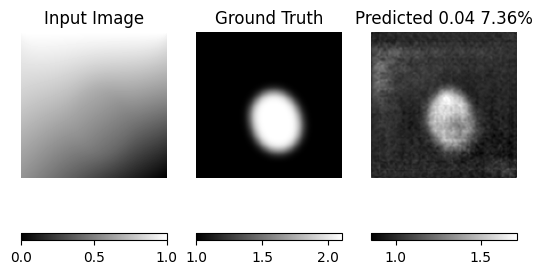

In [80]:
fit(train_dataset,val_dataset, epochs=EPOCH)

In [81]:
len(gen_total_loss_list)

790

In [82]:
len(gen_val_loss_list)

20000

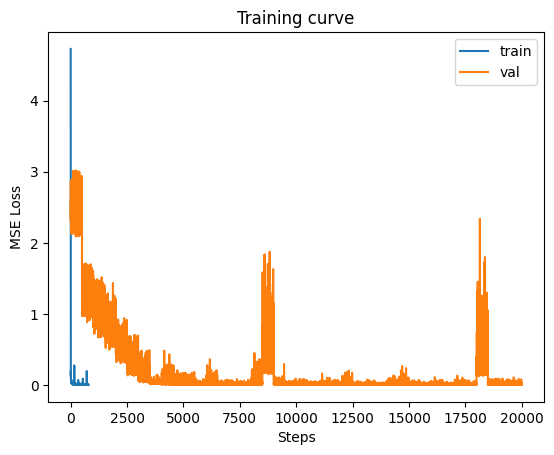

In [83]:
# plt.figure(figsize=(20, 15))
plt.plot(gen_total_loss_list, label='train')
plt.plot(gen_val_loss_list, label='val')
plt.title("Training curve")
plt.xlabel("Steps")
plt.ylabel("MSE Loss")
plt.legend()
plt.savefig('results/train_val_curve.png')
plt.show()


In [84]:
l1 = len(epoch_wise_train_loss)
l2 = len(epoch_wise_val_loss)
print(l1)
print(l2)
a = range(1,l1+1)
b = range(1,l2+1)

5
5


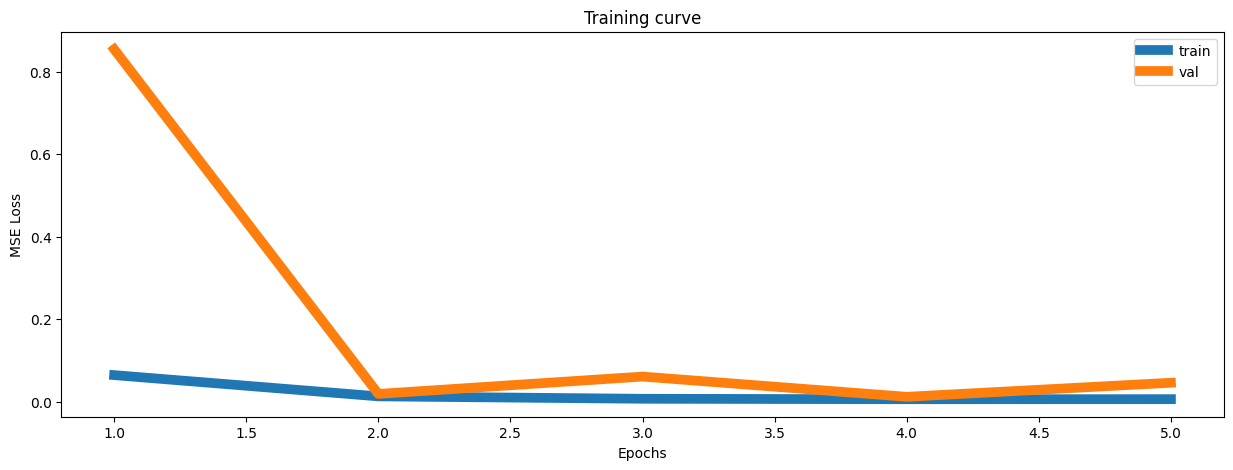

In [85]:
plt.figure(figsize=(15,5))
plt.plot(a, epoch_wise_train_loss, label='train', linewidth=7.0)
plt.plot(a, epoch_wise_val_loss, label='val', linewidth=7.0)
plt.title("Training curve")
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.legend()
plt.savefig('results/train_val_epoch_curve.png')
plt.show()

In [86]:
with open("epoch_wise_train_loss", "wb") as fp:   
    pickle.dump(epoch_wise_train_loss, fp)
with open("epoch_wise_val_loss", "wb") as fp:   
    pickle.dump(epoch_wise_val_loss, fp)

In [87]:
print(f'Train MSE at the end of training: {gen_total_loss_list[-1]}')
print(f'Val MSE at the end of training: {gen_val_loss_list[-1]}')

Train MSE at the end of training: 0.002524134237319231
Val MSE at the end of training: 0.002184654353186488


### Testing

In [88]:
generator.load_weights(BEST_PATH)

In [89]:
len(val_dataset)

1000

In [90]:
avg_mse_loss_list = []
avg_mape_loss_list = []

i = 0
for test_image,test_target in val_dataset:
    test_prediction = generator(test_image,training=True)
    test_target = test_target
    mse_loss = tf.keras.metrics.mean_squared_error(test_target, test_prediction)
    avg_mse_loss = tf.math.reduce_mean(mse_loss).numpy()
    avg_mse_loss_list.append(avg_mse_loss)

    mape_loss =  tf.keras.metrics.mean_absolute_percentage_error(test_target, test_prediction)
    avg_mape_loss = tf.math.reduce_mean(mape_loss).numpy()
    avg_mape_loss_list.append(avg_mape_loss)

    output = np.reshape(test_prediction, (128,128))
    gt = np.reshape(test_target, (128,128))
    i = i+1

    file_name = f"results/raw_vals/{i}-pred.raw"
    with open(file_name, 'wb') as fp:     
        output.tofile(fp)
    fp.close()

    file_name2 = f"results/raw_vals/{i}-gt.raw"
    with open(file_name2, 'wb') as fp:     
        gt.tofile(fp)
    fp.close()

2023-07-28 09:53:15.174684: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1000]
	 [[{{node Placeholder/_1}}]]


In [91]:
len(avg_mse_loss_list)

1000

In [ ]:
final_mse = sum(avg_mse_loss_list)/len(avg_mse_loss_list)
with open(f'{RESULTS_FOLDER}/loss.txt','a') as f:
    f.write(f'\nFinal_MSE:{final_mse}')
final_mse

In [ ]:
len(avg_mape_loss_list)

In [ ]:
final_mape = sum(avg_mape_loss_list)/len(avg_mape_loss_list)
with open(f'{RESULTS_FOLDER}/loss.txt','a') as f:
    f.write(f'\nFinal_MAPE:{final_mape}')
final_mape

In [ ]:
i = 0
for test_image,test_target in val_dataset:
    i = i+1
    generate_images(generator, test_image, test_target,'val-',i)

In [ ]:
i = 0
for test_image,test_target in val_dataset:
    i = i+1
    generate_images8(generator, test_image, test_target,'val2222-',i)

In [ ]:
# Generate plots for test set
# for i, (test_input, test_target) in val_dataset.take(500).enumerate():
#     generate_images(generator, test_input, test_target,'test',i)

In [ ]:
## Calculate modulus

In [ ]:
# all_raw_data_path = 'raw_exps/*.raw'
# all_raw_data = glob.glob(all_raw_data_path)

In [ ]:
# all_raw_data.sort(key=lambda x: int(x.split('/')[-1].split('.')[0]))
# all_raw_data

In [ ]:
# threshold = 0.45

In [ ]:
# all_modulus = []

In [ ]:
# for a_data in all_raw_data:
#     img = np.fromfile(a_data,dtype = 'float32', sep="")
#     name = a_data.split('/')[-1].split('.')[0]
#     modulus = img[img<threshold]
#     if len(modulus) != 0:
#         avg_modulus = sum(modulus)/len(modulus)
    
#     all_modulus.append((name,avg_modulus))

#     with open('modulus_values.txt', 'a') as f:
#         f.write(f"{name},{avg_modulus}\n")
    
    

In [ ]:
# for i in all_modulus:
#     print(i)